<a href="https://colab.research.google.com/github/fact-h/Graduation-project/blob/main/LightGBM_v4_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 基于机器学习的城市洪涝快速模拟研究

- 目标：根据降雨和潮位的序列信息预测某点的最大水深
- 使用的机器学习算法：[LightGBM](https://lightgbm.readthedocs.io/en/latest/)
- 模型输入特征：10个降雨和潮位特征、1个淹没点分类特征
- 模型输出变量：最大水深
- 选取点：

1. SJ10401 
2. SJ18385 
3. SJ16484
4. SJ20705 
5. SJ13082 
6. SJ8600 
7. SJ10479 
8. SJ14592
9. SJ15316
10. SJ21244


v4.0：更改数据划分方式，将随机划分改为人为划分

v3.0：增加了一列关于点名称的特征，选取10个点，可预测这10个点的最大水深。

v2.0：相较于v1.0，本版本增加了多个学习模型作为基准模型，以验证LightGBM模型的性能。

结果：

|	方法	|	LightGBM	|	RF	|	XGBoost	| SVR |	决策树 | KNN |
|	-------  |	------------	| ------- | ----------- | ----- | -------- | -----|
|	NSE		|	     |  |      |  |  |  |

v1.1：增加了特征重要性绘制

v1.0：完成基础功能--训练和预测，RMSE、NSE指标评估

## 导入相关的模块

In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from matplotlib import pyplot as plt

%matplotlib inline

try:
    # To enable interactive mode you should install ipywidgets
    # https://github.com/jupyter-widgets/ipywidgets
    from ipywidgets import interact, SelectMultiple
    INTERACTIVE = True
except ImportError:
    INTERACTIVE = False

## 加载原始数据
先上传两个CSV数据文件：
- `E:\毕业设计\数据\模型训练数据\X.csv`
- `E:\毕业设计\数据\模型训练数据\y.csv`

X数据集存储的是各降雨和潮位的时间序列，每一列是一个序列，y数据集存储的里是各点的最大水深，这两个数据集并不是模型直接使用的数据，模型使用的数据是提取特征后的数据，后面会进行特征的提取。

In [ ]:
df_X_raw = pd.read_csv('/content/X.csv')
df_y = pd.read_csv('/content/y.csv')

## 提取特征
10个特征：
- 6个降雨相关的特征：**累计降雨量 降雨重现期 降雨峰值 最大2h降雨量 最大3h降雨量 峰值前累计降雨量**
- 4个潮位相关的特征：**最大潮位 潮位重现期 平均潮位 最大5h平均潮位**

In [ ]:
#@title 创建降雨的特征DataFrame: `rain_feature_df`和创建潮位的有关特征DataFrame: `tide_feature_df` { display-mode: "form" }
# 新建一个降雨DataFrame
rain_feature_df = pd.DataFrame()

# 添加累计降雨量
rain_feature_df['CumRainfall'] = df_X_raw.iloc[:,2:9].sum()

# 添加降雨重现期
rain_feature_df['RainRP'] = [5,10,20,35,50,75,100]

# 添加降雨峰值
rain_feature_df['RainfallPeak'] = df_X_raw.iloc[:,2:9].max()

# 添加最大2h降雨量
rain_feature_df['MaxRainfall2h'] = np.add(df_X_raw.iloc[0:-2,2:9], df_X_raw.iloc[1:-1,2:9]).max()

# 添加最大3h降雨量
rain_feature_df['MaxRainfall3h'] = np.add(np.add(df_X_raw.iloc[0:-3,2:9],df_X_raw.iloc[1:-2,2:9]),df_X_raw.iloc[2:-1,2:9]).max()

# 添加峰值前累计降雨量
peak_index = df_X_raw[df_X_raw.iloc[:,2]==rain_feature_df['RainfallPeak'][0]].index.tolist()[0]
rain_feature_df['CumRainfallBeforePeak'] = df_X_raw.iloc[0:peak_index,2:9].sum()



# 创建一个从潮位中提取的特征DataFrame
tide_feature_df = pd.DataFrame()

# 添加最大潮位
tide_feature_df['MaxTide'] = df_X_raw.iloc[:,9:].max()

# 添加潮位重现期
tide_feature_df['TideRP'] = [5,10,20,35,50,75,100]

# 添加平均潮位
tide_feature_df['MeanTide'] = df_X_raw.iloc[:,9:].mean()

# 添加最大5h平均潮位
tide_feature_df['MaxTide5h'] = np.add(
    np.add(np.add(
        np.add(df_X_raw.iloc[0:-5,9:],df_X_raw.iloc[1:-4,9:]),
        df_X_raw.iloc[2:-3,9:]),df_X_raw.iloc[3:-2,9:]),
        df_X_raw.iloc[4:-1,9:]).max()/5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy 

## 组合数据

### 将降雨特征、潮位特征和最大水深组合在一起，形成490条数据样本
先将降雨的每一行复制7遍，再用`concat`方法将7组潮位数据首尾相连，即相当于整个复制7遍。

然后使用`join`方法连接降雨和潮位，每个重现期的降雨对应7个重现期的潮位。最后再将水深数据加上，得到总的数据集`df_data`。

In [ ]:
# 重置索引，将索引换为数字形式，方便后面数据组合
rain_feature_df = rain_feature_df.reset_index(drop=True) # 重置索引后将原索引所在的列删除
tide_feature_df = tide_feature_df.reset_index(drop=True)

# 将降雨数据的每一行复制7遍
rain_repeat_df = pd.DataFrame(np.repeat(rain_feature_df.values,tide_feature_df.shape[0],axis=0)) 
rain_repeat_df.columns = rain_feature_df.columns
# 将所有潮位数据整体复制7遍，concat方法是拼接数据
tide_concat_df = pd.concat([tide_feature_df, tide_feature_df, tide_feature_df, tide_feature_df, tide_feature_df, tide_feature_df, tide_feature_df]).reset_index(drop=True) 

# 组合降雨和潮位特征数据
df_X = rain_repeat_df.join(tide_concat_df)
# 将降雨潮位数据整体复制10遍
df_X_concat = pd.DataFrame()
for i in range(10):
  df_X_concat = pd.concat([df_X_concat, df_X])
df_X_concat = df_X_concat.reset_index(drop=True)
# 添加输出变量-水深
df_data = df_X_concat.join(df_y['depth'])
df_data

,CumRainfall,RainRP,RainfallPeak,MaxRainfall2h,MaxRainfall3h,CumRainfallBeforePeak,MaxTide,TideRP,MeanTide,MaxTide5h,depth
0,199.101882,5.0,56.394737,86.377019,99.455229,35.806351,2.898900,5,1.872049,2.579491,0.34
1,199.101882,5.0,56.394737,86.377019,99.455229,35.806351,3.159600,10,2.040403,2.811467,0.39
2,199.101882,5.0,56.394737,86.377019,99.455229,35.806351,3.400900,20,2.196230,3.026179,0.43
3,199.101882,5.0,56.394737,86.377019,99.455229,35.806351,3.585497,35,2.315439,3.190437,0.48
4,199.101882,5.0,56.394737,86.377019,99.455229,35.806351,3.701200,50,2.390157,3.293392,0.53
...,...,...,...,...,...,...,...,...,...,...,...
485,406.171863,100.0,115.046402,176.210865,202.890676,73.045680,3.400900,20,2.196230,3.026179,0.66
486,406.171863,100.0,115.046402,176.210865,202.890676,73.045680,3.585497,35,2.315439,3.190437,0.76
487,406.171863,100.0,115.046402,176.210865,202.890676,73.045680,3.701200,50,2.390157,3.293392,0.83
488,406.171863,100.0,115.046402,176.210865,202.890676,73.045680,3.827370,75,2.471635,3.405660,0.90


### 数据归一化

In [ ]:
# 归一化：z-score
df_data_mean = df_data.mean()
df_data_std = df_data.std()
df_data_norm = (df_data - df_data.mean()) / df_data.std()

# 添加淹没点数据列，形成最终数据集
df_data_norm.insert(df_data_norm.shape[1]-1,df_y.columns[2],df_y.values[:,2])
df_data_norm

,CumRainfall,RainRP,RainfallPeak,MaxRainfall2h,MaxRainfall3h,CumRainfallBeforePeak,MaxTide,TideRP,MeanTide,MaxTide5h,Point,depth
0,-1.650700,-1.137918,-1.650700,-1.650700,-1.650700,-1.650700,-1.754695,-1.137918,-1.754695,-1.754695,0.0,-1.529307
1,-1.650700,-1.137918,-1.650700,-1.650700,-1.650700,-1.650700,-0.992038,-0.984737,-0.992038,-0.992038,0.0,-1.328879
2,-1.650700,-1.137918,-1.650700,-1.650700,-1.650700,-1.650700,-0.286134,-0.678374,-0.286134,-0.286134,0.0,-1.168537
3,-1.650700,-1.137918,-1.650700,-1.650700,-1.650700,-1.650700,0.253890,-0.218830,0.253890,0.253890,0.0,-0.968109
4,-1.650700,-1.137918,-1.650700,-1.650700,-1.650700,-1.650700,0.592369,0.240713,0.592369,0.592369,0.0,-0.767681
...,...,...,...,...,...,...,...,...,...,...,...,...
485,1.317914,1.772526,1.317914,1.317914,1.317914,1.317914,-0.286134,-0.678374,-0.286134,-0.286134,9.0,-0.246567
486,1.317914,1.772526,1.317914,1.317914,1.317914,1.317914,0.253890,-0.218830,0.253890,0.253890,9.0,0.154289
487,1.317914,1.772526,1.317914,1.317914,1.317914,1.317914,0.592369,0.240713,0.592369,0.592369,9.0,0.434888
488,1.317914,1.772526,1.317914,1.317914,1.317914,1.317914,0.961471,1.006620,0.961471,0.961471,9.0,0.715487


### 数据增强，并打乱数据

In [ ]:
# 选择34场工况作为训练集，10场作为验证集，5场作为测试集，选取的测试工况为5，20，35，75，100

test_df = pd.read_csv('/content/test.csv') # 50组测试集数据

train_df = df_data_norm.drop(index=test_df.idx,axis='row')
train_df = train_df.reset_index(drop='True')
test_df = test_df.drop(columns='idx',axis='column')

In [ ]:
# 打乱数据
train_valid = train_df.reindex(np.random.permutation(train_df.index))
test_df = test_df.reindex(np.random.permutation(test_df.index))

train_valid = train_valid.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [ ]:
'''
# 打乱数据
df_all_data = df_data_norm.reindex(np.random.permutation(df_data_norm.index))
df_all_data = df_all_data.reset_index(drop=True)
'''

# 将Point列设为类别特征，训练LightGBM时不用one-hot编码
train_valid['Point'].astype('category')
test_df['Point'].astype('category')

### 划分训练集、验证集和测试集

In [ ]:
# 创建训练集、验证集和测试集
# 342组训练集数据，98组验证集数据，50组测试集数据
val_split = round(0.2 * df_data_norm.shape[0]) 


y_test = test_df.depth
y_val = train_valid.depth[0:val_split]
y_train = train_valid.depth[val_split:]

X_test = test_df.drop(['depth'], axis=1)
X_val = train_valid[0:val_split].drop(['depth'], axis=1)
X_train = train_valid[val_split:].drop(['depth'], axis=1)

## 构建LightGBM模型进行训练

In [ ]:
evals_result = {} # 为绘图记录评估结果
gbm = lgb.LGBMRegressor(learning_rate=0.04,
                        n_estimators=500,
                        n_jobs=4)
gbm.fit(X_train,y_train,
        categorical_feature=['Point'], # 指定分类特征
        eval_set=[(X_val,y_val)],
        eval_metric=['rmse','l1'],
        callbacks=[lgb.early_stopping(5), lgb.record_evaluation(evals_result)],
        verbose=False)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Point']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 5 rounds.
Early stopping, best iteration is:
[457]	valid_0's rmse: 0.108744	valid_0's l1: 0.071311	valid_0's l2: 0.0118252


LGBMRegressor(learning_rate=0.04, n_estimators=500, n_jobs=4)

## 对分类特征应用 one-hot 编码

In [ ]:
# 对分类特征进行one-hot编码，供后续模型使用
# 分类特征
object_cols = ['Point']
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[object_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.fit_transform(X_val[object_cols]))
OH_cols_test = pd.DataFrame(OH_encoder.fit_transform(X_test[object_cols]))

# One-hot编码删掉了索引，需要加回来
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_val.index
OH_cols_test.index = X_test.index

# 删除分类列（将取代为one-hot编码）
num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_val.drop(object_cols, axis=1)
num_X_test = X_test.drop(object_cols, axis=1)

# 将one-hot编码后的列加到数值特征中
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)
OH_X_test = pd.concat([num_X_test, OH_cols_test], axis=1)


## 构建RF模型


In [ ]:
forest_model = RandomForestRegressor(random_state=1)
forest_model.fit(OH_X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


RandomForestRegressor(random_state=1)

## 构建XGBoost模型

In [ ]:
xgb_model = XGBRegressor(learning_rate=0.03, n_estimators=300, n_jobs=4)
xgb_model.fit(OH_X_train,y_train,
              early_stopping_rounds=5,
              eval_set=[(OH_X_valid,y_val)],
              verbose=False)

[08:05:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(learning_rate=0.03, n_estimators=300, n_jobs=4)

# 构建SVR模型

In [ ]:
SVR_model = SVR()
SVR_model.fit(OH_X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


SVR()

## 构建决策树模型

In [ ]:
DT_model = DecisionTreeRegressor()
DT_model.fit(OH_X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


DecisionTreeRegressor()

## 构建KNN模型

In [ ]:
KNN_model = KNeighborsRegressor()
KNN_model.fit(OH_X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


KNeighborsRegressor()

## 绘制训练过程中的指标变化情况

In [ ]:
def render_metric(metric_name):
    ax = lgb.plot_metric(evals_result, metric=metric_name, figsize=(10, 5))
    plt.show()

if INTERACTIVE:
    # create widget to switch between metrics
    interact(render_metric, metric_name=['rmse','l2'])
else:
    render_metric('rmse')

interactive(children=(Dropdown(description='metric_name', options=('rmse', 'l2'), value='rmse'), Output()), _d…

## 绘制特征重要性

In [ ]:
def render_plot_importance(importance_type, max_features=10,
                           ignore_zero=True, precision=3):
    ax = lgb.plot_importance(gbm, importance_type=importance_type,
                             max_num_features=max_features,
                             ignore_zero=ignore_zero, figsize=(12, 8),
                             precision=precision)
    plt.show()

if INTERACTIVE:
    # create widget for interactive feature importance plot
    interact(render_plot_importance,
             importance_type=['split', 'gain'],
             max_features=(1, X_train.shape[-1]),
             precision=(0, 10))
else:
    render_plot_importance(importance_type='split')

interactive(children=(Dropdown(description='importance_type', options=('split', 'gain'), value='split'), IntSl…

## 在测试集上进行预测并评估
评估指标：
- RMSE
- NSE / $R^2$

*均在未归一化的原始数据上评估*

In [ ]:
# 在测试集上预测
y_pred = gbm.predict(X_test,num_iteration=gbm.best_iteration_)

# RMSE评估
rmse_test = mean_squared_error(y_test, y_pred) ** 0.5
#print(f'The RMSE of prediction is: {rmse_test}')

y_pred_raw = y_pred * df_data_std.depth + df_data_mean.depth
y_test_raw = y_test * df_data_std.depth + df_data_mean.depth
rmse_test_raw = mean_squared_error(y_test_raw,y_pred_raw) ** 0.5 # mse加根号即是rmse
print(f'The RMSE of raw prediction is: {rmse_test_raw}')

mape = mean_absolute_percentage_error(y_test_raw,y_pred_raw)
print(f'The MAPE of raw prediction is: {mape}')

# 计算纳什效率系数
H_obs = y_test
H_m = y_pred
H_obs_mean = H_obs.mean()
SSE = ((H_obs - H_m)**2).sum()
SST = ((H_obs - H_obs_mean)**2).sum()
NSE = 1 - SSE / SST
n = y_test.shape[0]
k = X_test.shape[1]
Adjusted_R2 = 1 - (1 - NSE) * (n-1) / (n-k-1)
print(f'The SSE of raw prediction is: {SSE}')
print(f'The NSE of raw prediction is: {NSE}')
print(f'The adjusted R2 of raw prediction is: {Adjusted_R2}')

# 计算R2_score
#R2 = r2_score(y_test_raw,y_pred_raw)
#print(f'The R2 score of prediction is: {R2}')

The RMSE of raw prediction is: 0.024169668751801553
The MAPE of raw prediction is: 0.034775545443422845
The SSE of raw prediction is: 0.46934110161789805
The NSE of raw prediction is: 0.992843912540691
The adjusted R2 of raw prediction is: 0.9907724135393121


## 评估RF模型

In [ ]:
RF_preds = forest_model.predict(OH_X_test)

# RMSE评估
RF_pred_raw = RF_preds * df_data_std.depth + df_data_mean.depth
RF_test_raw = y_test * df_data_std.depth + df_data_mean.depth
rmse_test_raw = mean_squared_error(RF_test_raw,RF_pred_raw) ** 0.5 # mse加根号即是rmse
print(f'The RMSE of raw prediction is: {rmse_test_raw}')

mape = mean_absolute_percentage_error(RF_test_raw,RF_pred_raw)
print(f'The MAPE of raw prediction is: {mape}')

# 计算纳什效率系数
H_obs = y_test
H_m = RF_preds
H_m_mean = H_obs.mean()
SSE = ((H_obs - H_m)**2).sum()
SST = ((H_obs - H_obs_mean)**2).sum()
NSE = 1 - SSE / SST
n = y_test.shape[0]
k = OH_X_test.shape[1]
Adjusted_R2 = 1 - (1 - NSE) * (n-1) / (n-k-1)
print(f'The SSE of raw prediction is: {SSE}')
print(f'The NSE of raw prediction is: {NSE}')
print(f'The adjusted R2 of raw prediction is: {Adjusted_R2}')

The RMSE of raw prediction is: 0.03682897500246765
The MAPE of raw prediction is: 0.04521746699771148
The SSE of raw prediction is: 1.089748941074153
The NSE of raw prediction is: 0.9833844964693401
The adjusted R2 of raw prediction is: 0.9719255285171609


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


# 评估XGBoost模型

In [ ]:
xgb_preds = xgb_model.predict(OH_X_test)

# RMSE评估
xgb_pred_raw = xgb_preds * df_data_std.depth + df_data_mean.depth
xgb_test_raw = y_test * df_data_std.depth + df_data_mean.depth
rmse_test_raw = mean_squared_error(xgb_test_raw,xgb_pred_raw) ** 0.5 # mse加根号即是rmse
print(f'The RMSE of raw prediction is: {rmse_test_raw}')


# 计算纳什效率系数
H_obs = y_test
H_m = xgb_preds
H_m_mean = H_obs.mean()
SSE = ((H_obs - H_m)**2).sum()
SST = ((H_obs - H_obs_mean)**2).sum()
NSE = 1 - SSE / SST
n = y_test.shape[0]
k = OH_X_test.shape[1]
Adjusted_R2 = 1 - (1 - NSE) * (n-1) / (n-k-1)
print(f'The SSE of raw prediction is: {SSE}')
print(f'The NSE of raw prediction is: {NSE}')
print(f'The adjusted R2 of raw prediction is: {Adjusted_R2}')

The RMSE of raw prediction is: 0.03284418611261576
The SSE of raw prediction is: 0.8666909213547217
The NSE of raw prediction is: 0.9867854828566607
The adjusted R2 of raw prediction is: 0.977672022757806


## 评估SVR模型

In [ ]:
SVR_preds = SVR_model.predict(OH_X_test)

# RMSE评估
SVR_pred_raw = SVR_preds * df_data_std.depth + df_data_mean.depth
SVR_test_raw = y_test * df_data_std.depth + df_data_mean.depth
rmse_test_raw = mean_squared_error(SVR_test_raw,SVR_pred_raw) ** 0.5 # mse加根号即是rmse
print(f'The RMSE of raw prediction is: {rmse_test_raw}')


# 计算纳什效率系数
H_obs = y_test
H_m = SVR_preds
H_m_mean = H_obs.mean()
SSE = ((H_obs - H_m)**2).sum()
SST = ((H_obs - H_obs_mean)**2).sum()
NSE = 1 - SSE / SST
n = y_test.shape[0]
k = OH_X_test.shape[1]
Adjusted_R2 = 1 - (1 - NSE) * (n-1) / (n-k-1)
print(f'The SSE of raw prediction is: {SSE}')
print(f'The NSE of raw prediction is: {NSE}')
print(f'The adjusted R2 of raw prediction is: {Adjusted_R2}')

The RMSE of raw prediction is: 0.052438774528080996
The SSE of raw prediction is: 2.209287621778356
The NSE of raw prediction is: 0.966314786005923
The adjusted R2 of raw prediction is: 0.9430836039410424


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


## 评估决策树模型

In [ ]:
DF_preds = DT_model.predict(OH_X_test)

# RMSE评估
DF_pred_raw = DF_preds * df_data_std.depth + df_data_mean.depth
DF_test_raw = y_test * df_data_std.depth + df_data_mean.depth
rmse_test_raw = mean_squared_error(DF_test_raw,DF_pred_raw) ** 0.5 # mse加根号即是rmse
print(f'The RMSE of raw prediction is: {rmse_test_raw}')


# 计算纳什效率系数
H_obs = y_test
H_m = DF_preds
H_m_mean = H_obs.mean()
SSE = ((H_obs - H_m)**2).sum()
SST = ((H_obs - H_obs_mean)**2).sum()
NSE = 1 - SSE / SST
n = y_test.shape[0]
k = OH_X_test.shape[1]
Adjusted_R2 = 1 - (1 - NSE) * (n-1) / (n-k-1)
print(f'The SSE of raw prediction is: {SSE}')
print(f'The NSE of raw prediction is: {NSE}')
print(f'The adjusted R2 of raw prediction is: {Adjusted_R2}')

The RMSE of raw prediction is: 0.03891015291320433
The SSE of raw prediction is: 1.2163906316773865
The NSE of raw prediction is: 0.9814535788258022
The adjusted R2 of raw prediction is: 0.968662943533252


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


## 评估KNN模型
注意力机制

In [ ]:
KNN_preds = KNN_model.predict(OH_X_test)

# RMSE评估
KNN_pred_raw = KNN_preds * df_data_std.depth + df_data_mean.depth
KNN_test_raw = y_test * df_data_std.depth + df_data_mean.depth
rmse_test_raw = mean_squared_error(KNN_test_raw,KNN_pred_raw) ** 0.5 # mse加根号即是rmse
print(f'The RMSE of raw prediction is: {rmse_test_raw}')


# 计算纳什效率系数
H_obs = y_test
H_m = KNN_preds
H_m_mean = H_obs.mean()
SSE = ((H_obs - H_m)**2).sum()
SST = ((H_obs - H_obs_mean)**2).sum()
NSE = 1 - SSE / SST
n = y_test.shape[0]
k = OH_X_test.shape[1]
Adjusted_R2 = 1 - (1 - NSE) * (n-1) / (n-k-1)
print(f'The SSE of raw prediction is: {SSE}')
print(f'The NSE of raw prediction is: {NSE}')
print(f'The adjusted R2 of raw prediction is: {Adjusted_R2}')

The RMSE of raw prediction is: 0.10474769686652134
The SSE of raw prediction is: 8.815280926680337
The NSE of raw prediction is: 0.8655925912470791
The adjusted R2 of raw prediction is: 0.7728978265898923


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


### 真实值和预测值及其绝对误差

In [ ]:
depth = [list(y_test_raw), list(y_pred_raw), list(RF_pred_raw), list(xgb_pred_raw), list(SVR_pred_raw), list(DF_pred_raw), list(KNN_pred_raw)]
depth = np.transpose(depth) # 转置
cols = ['Real', 'LGBM', 'RF', 'XGBoost', 'SVR', 'DF', 'KNN']
df = pd.DataFrame(data=depth,columns=cols)
df.to_csv('result.csv')

## 绘制各模型在测试集上的散点图

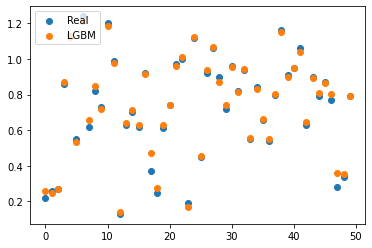

In [96]:
x = range(y_test.shape[0])
plt.scatter(x,y_test_raw,label='Real')
plt.scatter(x,y_pred_raw,label='LGBM')
#plt.scatter(x,RF_pred_raw,label='RF')
#plt.scatter(x,xgb_pred_raw,label='XGBoost')
#plt.scatter(x,SVR_pred_raw,label='SVR')
#plt.scatter(x,DF_pred_raw,label='DF')
#plt.scatter(x,KNN_pred_raw,label='KNN')
plt.legend(loc='upper left')